#Importantdo librerías (pandas, numpy, matplotlib, yfinance)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
pip install yfinance

#Paso 1 - Importación datos del BITCOIN, periodo de 7 dias y cada 5 minutos (300 segundos)

###creación de la función (obtener_datos_bitcoin_actualizados()) que actualiza la tabla cada vez que se invoque

In [20]:
def obtener_datos_bitcoin_actualizados():
    # Definiendo el símbolo de Bitcoin, que es 'BTC-USD' para Yahoo Finance
    bitcoin_symbol = 'BTC-USD'

    # Creando un objeto Ticker para Bitcoin
    bitcoin = yf.Ticker(bitcoin_symbol)

    # Obteniendo el historial de precios con intervalos de 5 minutos durante los últimos 7 días
    df_bitcoin = bitcoin.history(period='7d', interval='5m')

    return df_bitcoin

# Llamando a la función para obtener los datos actualizados de Bitcoin
df_bitcoin = obtener_datos_bitcoin_actualizados()

# Imprimir los datos
print(df_bitcoin)

                                   Open          High           Low  \
Datetime                                                              
2023-10-22 00:00:00+00:00  29918.654297  29921.863281  29904.357422   
2023-10-22 00:05:00+00:00  29901.482422  29904.847656  29900.773438   
2023-10-22 00:10:00+00:00  29915.406250  29939.906250  29915.406250   
2023-10-22 00:15:00+00:00  29948.679688  29960.902344  29948.679688   
2023-10-22 00:20:00+00:00  29963.044922  29963.503906  29961.232422   
...                                 ...           ...           ...   
2023-10-28 14:35:00+00:00  34105.167969  34105.167969  34092.398438   
2023-10-28 14:40:00+00:00  34102.031250  34102.031250  34086.812500   
2023-10-28 14:45:00+00:00  34086.660156  34086.660156  34072.312500   
2023-10-28 14:50:00+00:00  34090.625000  34101.156250  34086.078125   
2023-10-28 14:55:00+00:00  34096.847656  34096.847656  34096.847656   

                                  Close    Volume  Dividends  Stock Splits  

# Paso 2 - creacion de la funcion extraer_tendencias()
###utilizando webscraping para importar variables para la toma de decisiones
### definicion de las variables => global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

In [21]:
def estraer_tendencias():
    # Configuro el User-Agent
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'
    }

    # asigno el URL de la página de CoinMarketCap para el precio actual del Bitcoin
    url = "https://coinmarketcap.com/"

    # Realizo una solicitud GET a la página web con el User-Agent configurado
    respuesta = requests.get(url, headers=headers)

    # Verifico si la solicitud fue exitosa
    if respuesta.status_code == 200:
        soup = BeautifulSoup(respuesta.content, features="lxml")

        precio_actual = soup.findAll('div', {'class': 'sc-a0353bbc-0 gDrtaY'})
        #variacion = soup.findAll('span', {'class': 'icon-Caret-up'})
        variacion = soup.findAll('span', {'class': "sc-d55c02b-0 gUnzUB"})
        # Verificando que se encontraron elementos de precio_actual
        if precio_actual:
            precio_actual = float(precio_actual[0].text.strip().replace('$', '').replace(',', ''))

            # Verificando que se encontraron elementos de variación
            if variacion:
                tendencia = 'sube' if variacion[0].text[0] != '-' else 'baja'

                # Imprime los resultados
                print(f"Precio actual del Bitcoin: ${precio_actual:.2f}")
                print(f"Variación en la última hora: {variacion[0].text}")
                print(f"Tendencia: {tendencia}")
            else:
                print("No se encontraron elementos con la clase 'sc-d55c02b-0 iwhBxy'")
        else:
            print("No se encontraron elementos con la clase 'sc-a0353bbc-0 gDrtaY'")
    else:
        print(f"No se pudo acceder a la página (código de estado {respuesta.status_code}).")

estraer_tendencias()

Precio actual del Bitcoin: $34093.86
Variación en la última hora: 0.02%
Tendencia: sube


#Paso 3 - Limpieza de datos

##Vamos a eliminar datos nulos, outliers, y otros, para limpiar la base de datos cada vez que se cargue el historico de BTC

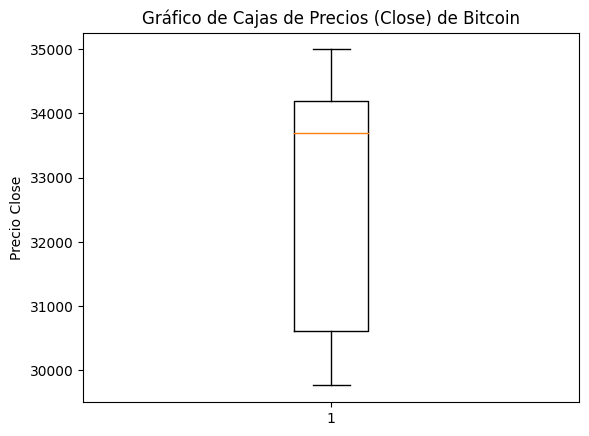

DataFrame Bitcoin Limpio:
                                   Open          High           Low  \
Datetime                                                              
2023-10-23 03:50:00+00:00  30650.539062  30683.857422  30602.603516   
2023-10-23 03:55:00+00:00  30665.847656  30747.738281  30665.847656   
2023-10-23 04:00:00+00:00  30728.923828  30791.951172  30714.619141   
2023-10-23 04:05:00+00:00  30785.207031  30792.054688  30652.412109   
2023-10-23 04:10:00+00:00  30655.880859  30661.757812  30642.345703   
...                                 ...           ...           ...   
2023-10-28 13:55:00+00:00  34086.308594  34131.277344  34082.003906   
2023-10-28 14:00:00+00:00  34132.839844  34132.839844  34098.429688   
2023-10-28 14:20:00+00:00  34126.609375  34126.609375  34114.359375   
2023-10-28 14:25:00+00:00  34109.742188  34114.449219  34076.531250   
2023-10-28 14:40:00+00:00  34102.031250  34102.031250  34086.812500   

                                  Close     Volume

In [22]:
def limpieza_datos(df_bitcoin):
    # Creo una copia del DataFrame para trabajar en ella
    df_bitcoin_limpio = df_bitcoin.copy()

    # Elimino duplicados en el índice y mantiene la primera ocurrencia
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Trato valores nulos en la columna Close
    df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

    # Elimino registros con 'Volume' = 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Identificando y eliminando outliers en la columna Close utilizando BOXPLOT
    plt.boxplot(df_bitcoin_limpio['Close'])
    plt.title('Gráfico de Cajas de Precios (Close) de Bitcoin')
    plt.ylabel('Precio Close')
    plt.show()

    limite_inferior = df_bitcoin_limpio['Close'].quantile(0.25)
    limite_superior = df_bitcoin_limpio['Close'].quantile(0.75)

    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= limite_inferior) & (df_bitcoin_limpio['Close'] <= limite_superior)]

    # Calculando el precio promedio (Close) de la selección
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    return df_bitcoin_limpio, media_bitcoin

# Llamando a la función con tu DataFrame df_bitcoin original
df_bitcoin_limpio, media_bitcoin = limpieza_datos(df_bitcoin)

# Imprimiendo el DataFrame limpio y el precio promedio
print("DataFrame Bitcoin Limpio:")
print(df_bitcoin_limpio)
print("Precio Promedio (Close) de Bitcoin Limpio:", media_bitcoin)


#Paso 4 - Toma de decisiones (sobre comprar o vender) analizando precio, media y tendencias

In [23]:
# Tenemos las variables globales: df_bitcoin_limpio (DataFrame limpio) y media_bitcoin (precio promedio)
# La logica en este caso es, si el precio esta bajo la media y en alza, hay que comprar
# Si el precio esta por encima de la media y esta a la baja, hay que vender.

def tomar_decisiones(df_bitcoin_limpio, precio_actual, tendencia):
    algoritmo_decision = ''
    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'sube':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

    return algoritmo_decision

precio_actual = 10  # Asigna un valor a precio_actual
tendencia = 'baja'  # Asigna un valor a tendencia

decision = tomar_decisiones(df_bitcoin_limpio, precio_actual, tendencia)
print("Decisión:", decision)

Decisión: Esperar


#Paso 5 - Visualizaciones

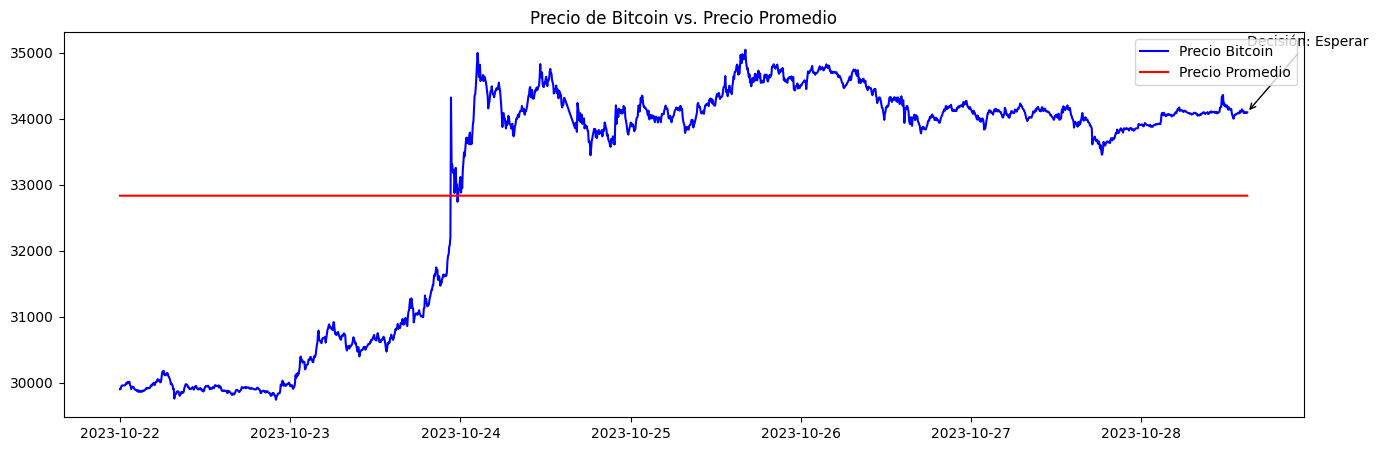

In [24]:
# Supongamos que tienes las variables globales: df_bitcoin (DataFrame original) y media_bitcoin (precio promedio)

def visualizacion():
    # Adiciono una nueva columna 'Promedio' al DataFrame original
    df_bitcoin['Promedio'] = media_bitcoin

    # Configuro el tamaño del gráfico
    plt.figure(figsize=(16, 5))

    # Añado un título al gráfico
    plt.title('Precio de Bitcoin vs. Precio Promedio')

    # Dibujo una línea con los datos del índice y la columna 'Close'
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Bitcoin', color='blue')

    # Dibujo una línea con los datos del índice y la columna 'Promedio'
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Precio Promedio', color='red')

    # Muestro la decisión en el gráfico
    decision = tomar_decisiones(df_bitcoin, df_bitcoin['Close'].iloc[-1], '{variacion[0].text}')  # Reemplaza con los valores adecuados
    plt.annotate(f'Decisión: {decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] + 1000), arrowprops=dict(arrowstyle='->'))

    # Muetro el gráfico
    plt.legend()
    plt.show()

# Llama a la función para generar el gráfico
visualizacion()


#Paso 6 - Automatizando el proceso

Precio actual del Bitcoin: $34093.86
Variación en la última hora: 0.02%
Tendencia: sube


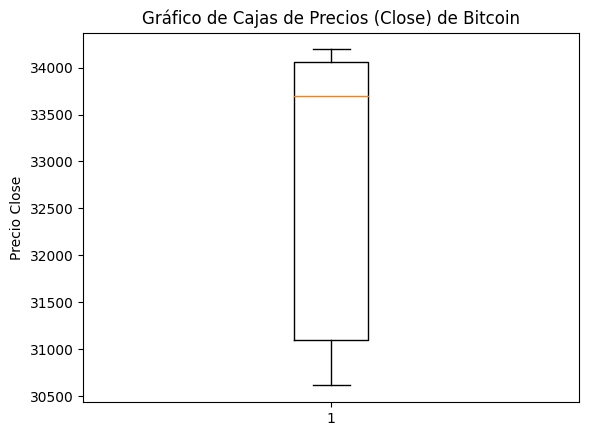

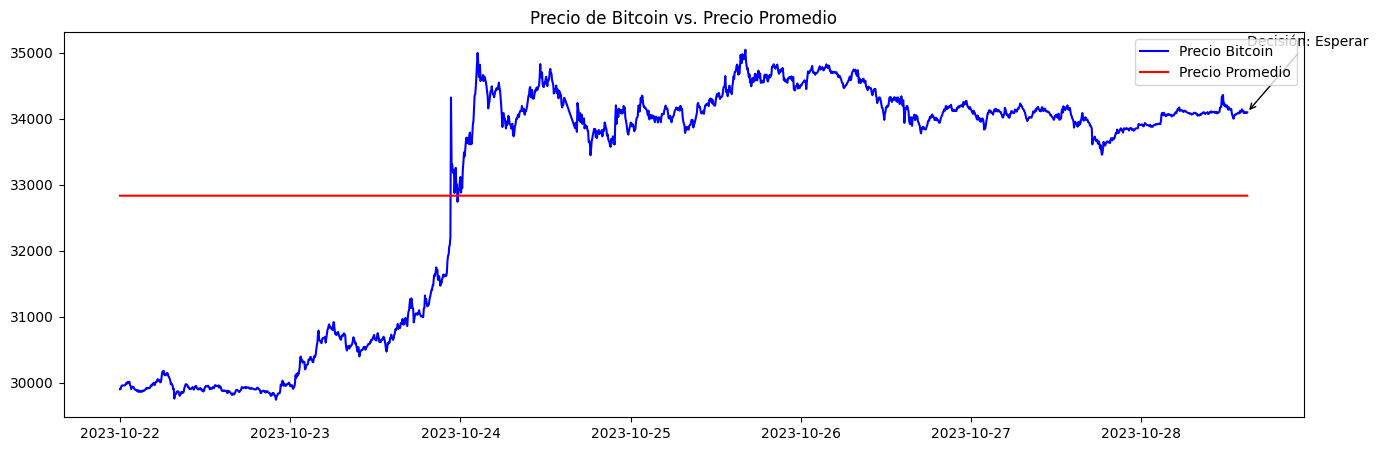

KeyboardInterrupt: ignored

In [25]:
# Define una función para realizar todo el proceso
def automatizar_proceso():
    clear_output()  # Borra resultados anteriores

    # Paso 2: Importar base de Bitcoin
    obtener_datos_bitcoin_actualizados()

    # Paso 3: Extraer tendencias
    estraer_tendencias()

    # Paso 4: Limpieza de datos
    limpieza_datos(df_bitcoin_limpio)

    # Paso 5 y 6: Toma de decisiones y visualización
    tomar_decisiones(df_bitcoin_limpio, precio_actual, tendencia)

    visualizacion()

while True:
    automatizar_proceso()
    time.sleep(300)  # Espera 300 segundos (5 minutos) antes de la próxima ejecución
